# Multi-Obejective Optimization of the Bhumibol Dam using Platypus

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq as root
from rhodium import *
from simulate_function import Simulate,Power_Generation,Objectives,Elevation,CubicRadialBasis
from platypus import NSGAII, Problem, Real
from mpl_toolkits.mplot3d import Axes3D
import pylab

ModuleNotFoundError: No module named 'rhodium'

Reading in the data and storing it as well as storing useful constants for later on

In [5]:
df = pd.read_csv('data.csv', index_col = 0, parse_dates=True, 
                 infer_datetime_format=True)
df = df.replace(0, np.NaN)
df = pd.concat([df.ffill(), df.bfill()]).groupby(level=0).mean()
    
STOR = df['stor']
INFLOW = df['infl24']
EVAP = df['evap']
REL = df['rel']
PUMP = df['pump8']
SPILL = df['spillway']
DEMAND = df['demand_irr']
FORE = df['fore']

T = len(STOR)
MAX_S = 13462
MAX_R = 64.5305
unit = 1
efficiency = 0.9
tail = 139
n = MAX_S + 312


## Simulating the Bhumibol Dam

Here direct policy searches are being generated using Standard Linear Operating Policy (SLOP).

We use decisions from SLOP as the releases used in the Simulate Dam function.

The three objectives that we are looking at are 1) The maximum value of release+spill at a given day 2) The total of all unmet irrigation demands 3) The total of all power generation

In [6]:
def BhumibolDam(x):
    
    weight = x[0:3]
    center = x[3:6]
    radius = x[6:9]

    S1 = np.zeros([T])
    R1 = np.zeros([T])
    P = np.zeros([T])
    spill = np.zeros([T])
    R_Decisions = np.zeros([T])
    S1[0] = STOR[0]
    R1[0] = REL[0]
    spill[0] = SPILL[0]
    elevation = np.zeros([T])
        
    #Simulate Dam
    for day in range(T-1):
        #infoList.append(Info(S1[day], day))
        R_Decisions[day] = CubicRadialBasis(S1[day], weight, center, radius)
        S1[day+1],R1[day],spill[day] = Simulate(S1[day], R_Decisions[day],
         INFLOW[day], EVAP[day], MAX_S, unit, spill[day], PUMP[day], MAX_R)
             
    for  day in range(T):
       elevation[day] = Elevation(S1[day])
       P[day]= Power_Generation(R1[day],efficiency,elevation[day], tail)
            
    #Optimization function
    MaxRel, UnmetDemand, PowerGen = Objectives(R1, DEMAND, spill,P); 
    
    return(MaxRel, UnmetDemand, PowerGen)

Here we run the evolutionary algorithm

In [3]:
problem = Problem(9,3)

problem.types[0:3] = Real(0, 1)
problem.types[3:6] = Real(0, n)
problem.types[6:9] = Real(0, n)
problem.function = BhumibolDam

algorithm = NSGAII(problem)
algorithm.run(100)

NameError: name 'Problem' is not defined

Now the objectives will be calculated over the historical data

In [5]:
Hist_P = np.zeros([T])

for  day in range(T):
       Hist_P[day]= Power_Generation(REL[day],efficiency, FORE[day], tail)
        
#Optimization function
H_MaxRel, H_UnmetDemand, H_PowerGen = Objectives(REL, DEMAND, SPILL, Hist_P); 


We plot in 3D how the generated policies perform with regard to the three objectives in blue and how the dam historical performed in red.

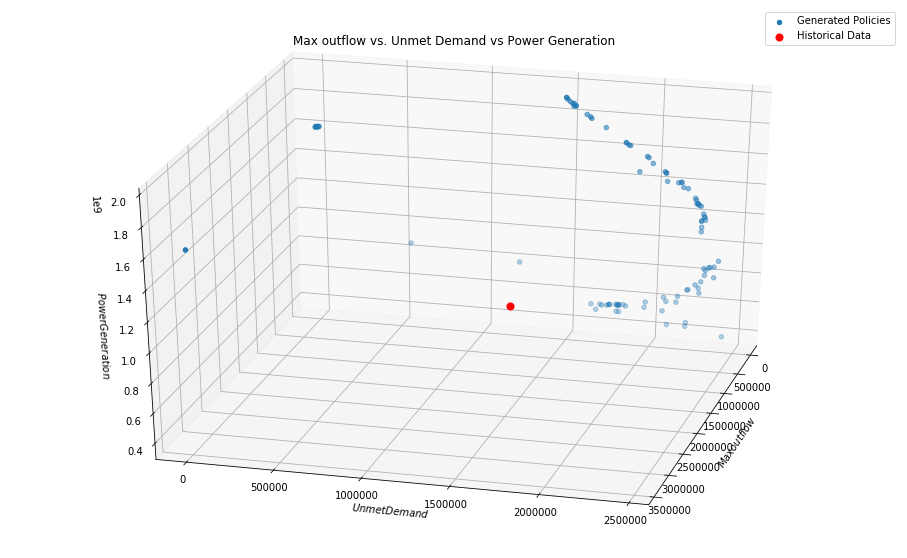

In [6]:
#increase figure size
pylab.rcParams['figure.figsize'] = (16, 10)


#Plot our 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
blue = ax.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result],
           [s.objectives[2] for s in algorithm.result])
ax.set_xlabel("$Max outflow$")
ax.set_ylabel("$Unmet Demand$")
ax.set_zlabel("$Power Generation$")
ax.view_init(elev=30.0, azim=15)
red = ax.scatter(H_MaxRel, H_UnmetDemand, H_PowerGen, c="Red", s= 50)
plt.title("Max outflow vs. Unmet Demand vs Power Generation")

plt.legend((blue, red), ('Generated Policies', 'Historical Data'))

plt.show()




Then, the 2D plots of how the historical data compares to the generated policies across the 3 objectives compare

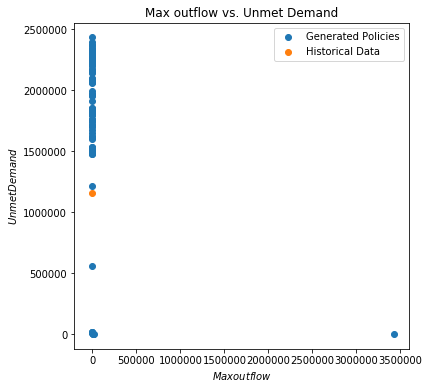

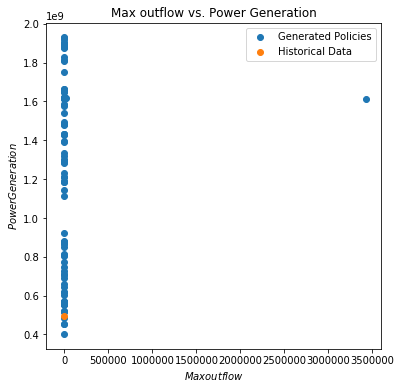

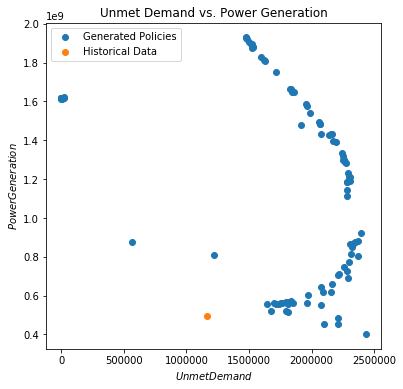

In [7]:
#determine the figure size
pylab.rcParams['figure.figsize'] = (6, 6)

#Make three separate scatter plots
plt.scatter([s.objectives[0] for s in algorithm.result],
            [s.objectives[1] for s in algorithm.result], label = "Generated Policies")

plt.scatter(H_MaxRel, H_UnmetDemand, label = "Historical Data")
plt.xlabel("$Max outflow$")
plt.ylabel("$Unmet Demand$")
plt.title("Max outflow vs. Unmet Demand")
plt.legend()
plt.show()

plt.scatter([s.objectives[0] for s in algorithm.result],
            [s.objectives[2] for s in algorithm.result], label = "Generated Policies")
plt.scatter(H_MaxRel, H_PowerGen, label = "Historical Data")
plt.xlabel("$Max outflow$")
plt.ylabel("$Power Generation$")
plt.title("Max outflow vs. Power Generation")
plt.legend()
plt.show()


plt.scatter([s.objectives[1] for s in algorithm.result],
            [s.objectives[2] for s in algorithm.result], label = "Generated Policies" )
plt.scatter(H_UnmetDemand, H_PowerGen, label = "Historical Data")
plt.xlabel("$Unmet Demand$")
plt.ylabel("$Power Generation$")
plt.title("Unmet Demand vs. Power Generation")
plt.legend()

plt.show()




We load the objectives objects in to a numpy array for better functionality than a list. We determine the index for the optimial policies in each objective. We also calculate the minimum and maximum values of each of the objectives for use later on.

In [8]:
#Transfer Objectives data in to numpy arrays
Obj1_array = np.array([])
Obj2_array = np.array([])
Obj3_array = np.array([])

for solution in algorithm.result:
    Obj1_array = np.append(Obj1_array, solution.objectives[0])
    Obj2_array = np.append(Obj2_array, solution.objectives[1])
    Obj3_array = np.append(Obj3_array, solution.objectives[2])

#Calculate indexes of optimal policies in t
ArgMin1 = np.argmin(Obj1_array)    
ArgMin2 = np.argmin(Obj2_array)
ArgMax3 = np.argmax(Obj3_array)

#Calculate the mins and maxes for the Objectives
minObj1 = np.min(Obj1_array)
minObj2 = np.min(Obj2_array)
minObj3 = np.min(Obj3_array)
maxObj1 = np.max(Obj1_array)
maxObj2 = np.max(Obj2_array)
maxObj3 = np.max(Obj3_array)

In [20]:
print(algorithm.result[34].variables)

[0.9292152073552453, 0.6817886743225858, 0.491693230440319, 448.2969856865018, 7536.254824338242, 13164.877968231425, 1466.8655475904916, 11173.104821443416, 2240.529542061965]


Now to create a plot that shows the optimal policies on a graph of release decisions vs. storage + inflow

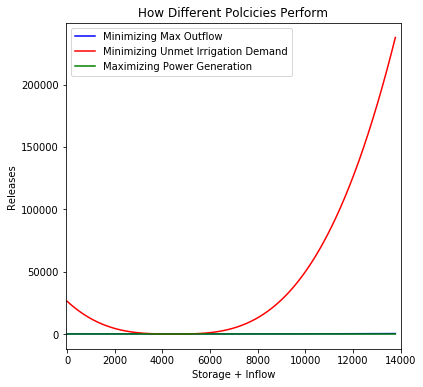

In [10]:
SI = np.arange(n)
Op1_Rel =  np.zeros([n])
Op2_Rel =  np.zeros([n])
Op3_Rel =  np.zeros([n])

#Store the variables HF, D 
Var1 = algorithm.result[ArgMin1].variables
Var2 = algorithm.result[ArgMin2].variables
Var3 = algorithm.result[ArgMax3].variables

#plug it back in the SLOP function to get the r_decisions
for day in range(n):
        Op1_Rel[day] = CubicRadialBasis(SI[day], Var1[0:3], Var1[3:6], Var1[6:9])
        Op2_Rel[day] = CubicRadialBasis(SI[day], Var2[0:3], Var2[3:6], Var2[6:9])
        Op3_Rel[day] = CubicRadialBasis(SI[day], Var3[0:3], Var3[3:6], Var3[6:9])
        
#make a plot
a = plt.plot(SI, Op1_Rel, c = 'blue', label = 'Minimizing Max Outflow')
b = plt.plot(SI, Op2_Rel, c = 'red', label = 'Minimizing Unmet Irrigation Demand')
c = plt.plot(SI, Op3_Rel, c = 'green', label = 'Maximizing Power Generation')

plt.xlabel('Storage + Inflow')
plt.ylabel('Releases')
plt.gca().set_xlim(-50, 14000) ;
plt.title('How Different Polcicies Perform')
plt.legend()
plt.show()

Now to create a parallel axis plot of the data. We have to scale the objectives to be between 0 and 1. We also highlight the three optimal policies for the three objectives.

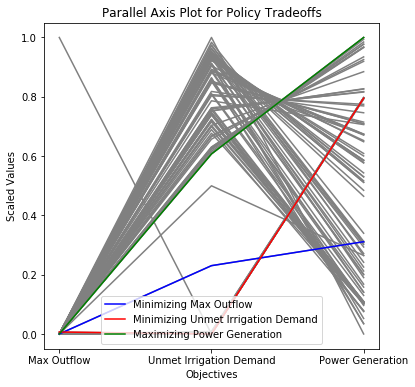

In [11]:
#Make a copy of the the algorithm results
scaled = 0
scaled = deepcopy(algorithm.result)

#plot every thing
for value in scaled:
    value.objectives[0] = (value.objectives[0] - minObj1) / (maxObj1- minObj1)
    value.objectives[1] = (value.objectives[1] - minObj2) / (maxObj2- minObj2)
    value.objectives[2] = (value.objectives[2] - minObj3) / (maxObj3- minObj3)

    plt.plot(range(3), value.objectives, color = 'grey', zorder = 2)
    

#plot the optimal policies
min1 = plt.plot(range(3), scaled[ArgMin1].objectives, color = 'blue', zorder = 2,
                label = 'Minimizing Max Outflow')
min2 = plt.plot(range(3), scaled[ArgMin2].objectives, color = 'red', zorder = 2, 
                label = 'Minimizing Unmet Irrigation Demand')
min3 = plt.plot(range(3), scaled[ArgMax3].objectives, color = 'green', zorder = 2,
                label = 'Maximizing Power Generation')

#edit the current axis to be in the objectives format
plt.gca().set_xticks(range(3))
plt.gca().set_xticklabels(['Max Outflow', 'Unmet Irrigation Demand', 'Power Generation'])

#format and show plot
plt.ylabel('Scaled Values')
plt.xlabel('Objectives')
plt.title('Parallel Axis Plot for Policy Tradeoffs')
plt.legend()
plt.show()

In [14]:
ArgMin2

0

In [15]:
ArgMax3

7

In [16]:
ArgMin1

34